In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from muniverse.algorithms.decomposition_methods import upper_bound, basic_cBSS
from muniverse.algorithms.decomposition_routines import *
from muniverse.evaluation.evaluate import *
from muniverse.data_preparation.data2bids import *
from pathlib import Path

In [2]:
BIDS_dataset = bids_dataset(datasetname='neuromotion_test', root=str(Path.home()) + '/Documents/muniverse-data/Datasets/')
df = BIDS_dataset.list_all_file('emg.edf')
filt_df = df[df['task'].str.contains('ECRBisometricradialtrapezoid')]
rec_idx = 139
emg_recording = bids_emg_recording(data_obj=BIDS_dataset,subject=1, datatype='emg')
emg_recording.read_data_frame(df, rec_idx)
emg_recording.read()

n_chan = emg_recording.emg_data.num_signals
idx = np.arange(emg_recording.emg_data.num_signals)
SIG = edf_to_numpy(emg_recording.emg_data,idx).T
fsamp = 2048

/Users/thomi/Documents/CBM/github/muniverse-demo/src/data_preparation/data2bids.py:65: ParserWarning: Skipping line 5: expected 2 fields, saw 3

  self.subjects_data = pd.read_table(name, on_bad_lines='warn')


In [ ]:
# Get the ground truth spikes
if emg_recording.session < 0:
    fname = f"{emg_recording.subject_name}_{emg_recording.task}_run-0{emg_recording.run}_spikes.tsv"
else:
    fname = f"{emg_recording.subject_name}_ses-0{emg_recording.session}_{emg_recording.task}_run-0{emg_recording.run}_spikes.tsv"
gt_spikes= pd.read_table(emg_recording.datapath+fname, on_bad_lines='warn')
gt_spikes = gt_spikes.rename(columns={'source_id': 'unit_id'})
gt_spikes = gt_spikes.rename(columns={'spike_time': 'timestamp'})
gt_spikes['spike_time'] = gt_spikes['timestamp'] / fsamp

In [ ]:
# Do upper bound decomposition given the original MUAPs
simjson = filt_df.loc[rec_idx, 'file_path'] + '/sub-sim00_ses-02_task-ECRBisometricradialtrapezoid30percentmvc_run-01_simulation.json'
muap_path = str(Path.home()) + '/Documents/muniverse-data/subject_0_ECRB_Radial-Ulnar-deviation_muaps.npy'
unique_labels = gt_spikes['unit_id'].unique()
UB = upper_bound(sil_th = 0.0, ext_fact = 8)
muap1, _, angle = UB.load_muaps(simjson,muap_path)
sources, spikes, sil, mu_filters = UB.decompose(SIG[idx,10000:50000], muap1[np.sort(unique_labels),:,:], fsamp)
ub_spikes = spike_dict_to_long_df(spikes)
ub_spikes = ub_spikes.rename(columns={'source_id': 'unit_id'})
ub_spikes['spike_time'] = ub_spikes['spike_time'] + 10000/fsamp
ub_spikes['timestamp'] = (ub_spikes['spike_time']*fsamp).astype(int)

Loading MUAPs from cache: /Users/thomi/Documents/muniverse-data/subject_0_ECRB_Radial-Ulnar-deviation_muaps.npy
Using 100 electrodes (columns: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
Selected 100 electrodes from original 320


In [ ]:
# Do an upper bound decomposition given the STA MUAPs
unique_labels = gt_spikes['unit_id'].unique()
muap = np.zeros((len(unique_labels), n_chan, 409))
for i in np.arange(len(unique_labels)):
    muap[i,:,:] = spike_triggered_average(SIG, np.asarray(gt_spikes[(gt_spikes['unit_id'] == i)]).astype(int), win=0.1)
muap = muap - np.mean(SIG[:,10000:50000],axis=1).reshape(-1,1)
sources2, spikes2, sil2, mu_filters2 = UB.decompose(SIG[idx,10000:50000], muap[np.sort(unique_labels),:,:], fsamp)
ub_spikes2 = spike_dict_to_long_df(spikes2)
ub_spikes2 = ub_spikes2.rename(columns={'source_id': 'unit_id'})
ub_spikes2['spike_time'] = ub_spikes2['spike_time'] + 10000/fsamp
ub_spikes2['timestamp'] = (ub_spikes2['spike_time']*fsamp).astype(int)

In [ ]:
# Solve a BSS problem to identify MN spike times
cBSS = basic_cBSS(sil_th = 0.85, ext_fact = 8)

sources3, spikes3, sil3, mu_filters3 = cBSS.decompose(SIG, fsamp)


cbss_spikes = spike_dict_to_long_df(spikes3, fsamp=fsamp)
cbss_spikes = cbss_spikes.rename(columns={'source_id': 'unit_id'})
cbss_spikes['spike_time'] = cbss_spikes['spike_time'] 
cbss_spikes['timestamp'] = (cbss_spikes['spike_time']*fsamp).astype(int)

In [ ]:
# Evaluate spike macthes of the upper bound decompositions
df1 = evaluate_spike_matches(ub_spikes, gt_spikes, t_start = 10000/fsamp, t_end = 50000/fsamp, pre_matched=True)
df2 = evaluate_spike_matches(ub_spikes2, gt_spikes, t_start = 10000/fsamp, t_end = 50000/fsamp, pre_matched=True)

Text(0, 0.5, 'CoV ISI')

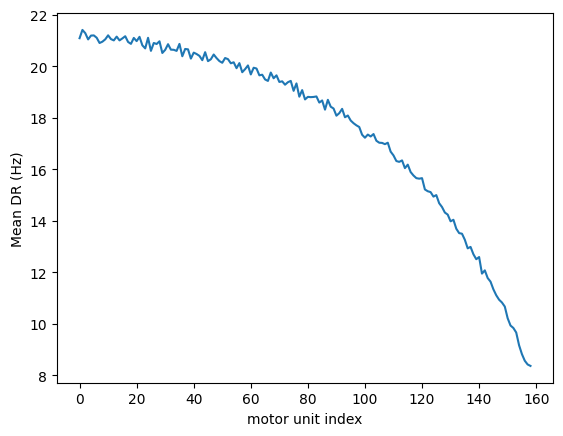

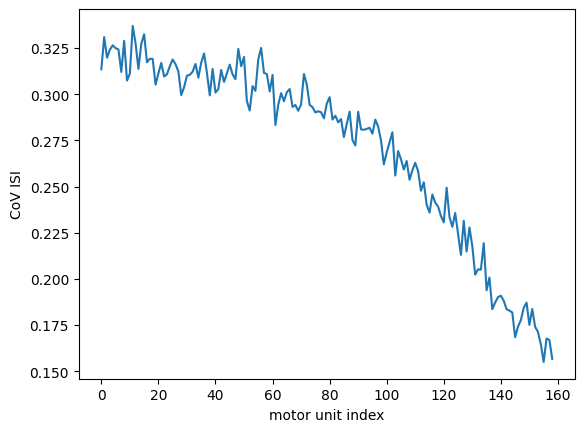

In [ ]:
# Check plausibility of ground truth spikes
fr = np.zeros(len(unique_labels))
cov_isi = np.zeros(len(unique_labels))

for i in np.arange(len(unique_labels)):
    spike_indices = gt_spikes[gt_spikes['unit_id'] == unique_labels[i]]['timestamp'].values.astype(int)
    fr[i] = 1 / np.mean(np.diff(spike_indices/fsamp))
    isi = np.diff(spike_indices/fsamp)
    cov_isi[i] = np.std(isi) / np.mean(isi)

plt.figure(0)
plt.plot(fr)
plt.xlabel('motor unit index')
plt.ylabel('Mean DR (Hz)')

plt.figure(1)
plt.plot(cov_isi)
plt.xlabel('motor unit index')
plt.ylabel('CoV ISI')
    

In [ ]:
# Check spike mtaches of the BSS decomposition
df3 = evaluate_spike_matches(cbss_spikes, gt_spikes, t_start = 10000/fsamp, t_end = 50000/fsamp)

35
60
23


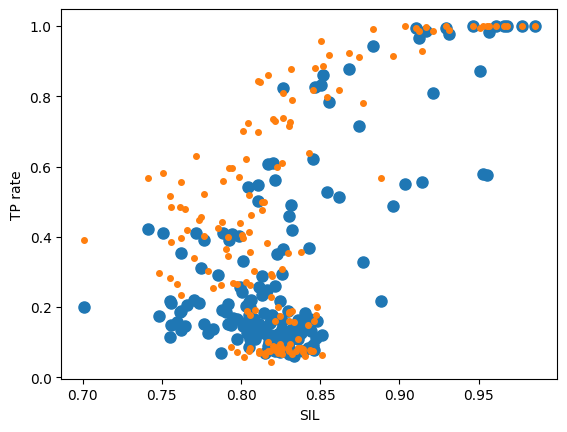

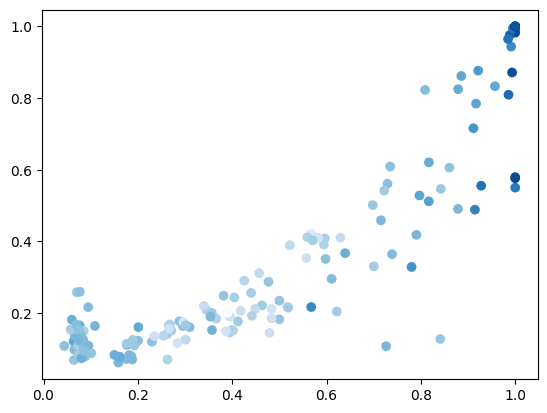

In [ ]:
# Quick overview of the decomposition results 

tpr1 = df1['TP'] / (df1['TP'] + df1['FP'])
print(np.sum(tpr1 > 0.5))

tpr2 = df2['TP'] / (df2['TP'] + df2['FP'])
print(np.sum(tpr2 > 0.5))

tpr3 = df3['TP'] / (df3['TP'] + df3['FP'])
print(np.sum(tpr3 > 0.5))

#print(df1)
plt.figure(2)
plt.plot(sil2, tpr1,'o', ms=8)
plt.plot(sil2, tpr2,'o', ms=4)
plt.xlabel('SIL')
plt.ylabel('TP rate')
plt.show()

colors = np.linspace(0,1,len(tpr1))

plt.figure(3)
plt.scatter(tpr2, tpr1,c=sil2, cmap='Blues')

In [11]:
print(df1[(df1['TP'] > (df1['FP']+ df1['FN'])) ])

#print(df2)

#print(df3)

     unit_id  unit_id_ref  delay_seconds   TP   FN   FP
64        64           64      -0.018066  279  138   60
77        77           77      -0.019043  338   61    5
92        92           92      -0.018555  293   87   47
104      104          104      -0.018555  338   13    2
109      109          109      -0.019531  285   53    5
116      116          116      -0.019531  231   81   49
126      126          126      -0.019531  275    1    0
127      127          127      -0.019531  218   53   13
129      129          129      -0.019043  246   18    6
130      130          130      -0.018555  204   51   56
132      132          132      -0.018555  233   15  169
133      133          133      -0.017578  175   69   35
137      137          137      -0.005859  200   27    1
139      139          139      -0.017090  215    0    0
141      141          141      -0.018555  174   28   69
142      142          142      -0.018555  193   12    7
144      144          144      -0.018555  185   

In [12]:
print(df2[(df2['TP'] > (df2['FP']+ df2['FN'])) ])

     unit_id  unit_id_ref  delay_seconds   TP   FN   FP
64        64           64      -0.019043  288  129   68
77        77           77      -0.019043  378   21    1
86        86           86      -0.018066  219  166   41
92        92           92      -0.018555  326   54   42
99        99           99      -0.017578  223  134   84
104      104          104      -0.018066  339   12    0
108      108          108      -0.006348  272   71   61
109      109          109      -0.019043  335    3    0
113      113          113      -0.018066  268   57   37
115      115          115      -0.017578  222   98   36
116      116          116      -0.019531  247   65   34
122      122          122      -0.019043  201   89   45
123      123          123      -0.018066  185  102   80
125      125          125      -0.018555  196   87   37
126      126          126      -0.019531  276    0    0
127      127          127      -0.019043  233   38    2
128      128          128      -0.019043  194   

In [13]:
print(df3[(df3['TP'] > (df3['FP']+ df3['FN'])) ])

    unit_id  unit_id_ref  delay_seconds   TP  FN  FP
0         0        152.0      -0.019531  151   1   0
1         1        139.0      -0.017090  215   0   1
2         2        126.0      -0.020508  276   0   0
3         3        109.0      -0.018066  331   7   1
4         4        146.0      -0.017578  181   0   0
5         5        132.0      -0.018555  247   1   0
6         6        154.0      -0.019531  138   0   0
7         7        155.0      -0.018555  130   1   0
8         8        104.0      -0.018555  341  10   0
9         9        158.0      -0.007324  117   4   0
11       11        129.0      -0.020020  259   5   2
12       12         77.0      -0.018066  368  31   1
13       13        141.0      -0.016602  177  25  86
14       14        137.0      -0.005859  206  21   1
15       15        153.0      -0.017090  134  12   1
16       16        148.0      -0.008301  130  45  40
17       17        108.0      -0.006348  272  71  16
18       18        127.0      -0.016602  230  

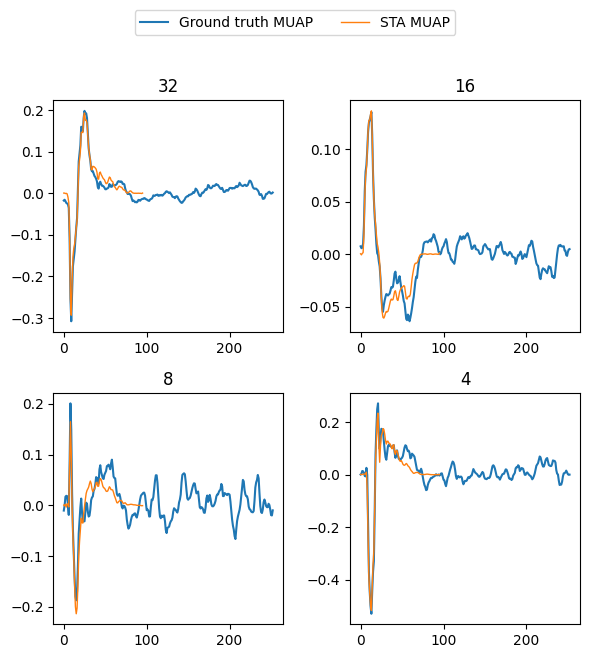

In [ ]:
# Compare STA and true MUAPs
mu_idx = 139

fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].plot(muap[mu_idx,32,156:],label='Ground truth MUAP')
axes[0, 0].plot(muap1[mu_idx,32,:], lw=1, label='STA MUAP')
axes[0, 0].set_title("32")

axes[0, 1].plot(muap[mu_idx,16,156:])
axes[0, 1].plot(muap1[mu_idx,16,:], lw=1)
axes[0, 1].set_title("16")

axes[1, 0].plot(muap[mu_idx,8,156:])
axes[1, 0].plot(muap1[mu_idx,8,:], lw=1)
axes[1, 0].set_title("8")

axes[1, 1].plot(muap[mu_idx,4,156:])
axes[1, 1].plot(muap1[mu_idx,4,:], lw=1)
axes[1, 1].set_title("4")

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)



plt.tight_layout()
plt.show()


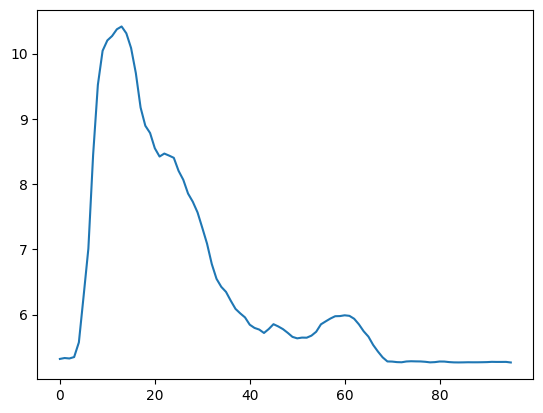

In [ ]:
# Showcase, what the upper bound optimization does
R=8
ext_sig = extension(SIG[:,10000:50000],R)
ext_mean = np.mean(ext_sig, axis=1, keepdims=True) 
ext_sig -= ext_mean
white_sig, Z = whitening(Y=ext_sig, method='ZCA')

ext_muap = extension(muap1[139,:,:]+0.0,R) 
ext_muap -= ext_mean

# Whiten the MUAP
white_muap = Z @ ext_muap

# Find the column with the largest L2 norm and return it as MUAP filter
col_norms = np.linalg.norm(white_muap, axis=0)

plt.plot(col_norms)

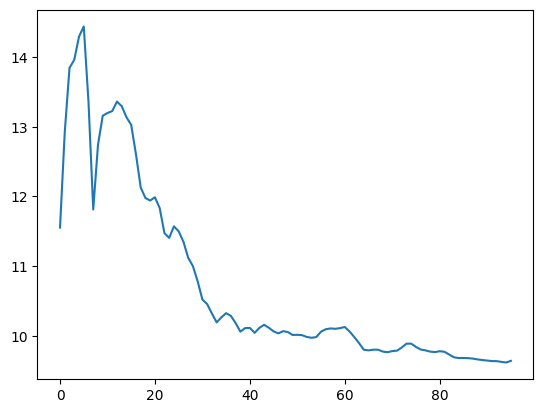

In [37]:
# Now showcase the effect of a sharp edge:

R=8
ext_sig = extension(SIG[:,10000:50000],R)
ext_mean = np.mean(ext_sig, axis=1, keepdims=True) 
ext_sig -= ext_mean
white_sig, Z = whitening(Y=ext_sig, method='ZCA')

ext_muap = extension(muap1[139,:,:]+0.1,R) 
ext_muap -= ext_mean

# Whiten the MUAP
white_muap = Z @ ext_muap

# Find the column with the largest L2 norm and return it as MUAP filter
col_norms = np.linalg.norm(white_muap, axis=0)

plt.plot(col_norms)